<a href="https://colab.research.google.com/github/ajaynain-eng/2D-to-3D-CNN-Pivotal-Teleradiology/blob/main/2D_to_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import os
 os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer

100% 5.99G/5.99G [02:10<00:00, 57.1MB/s]
100% 5.99G/5.99G [02:10<00:00, 49.4MB/s]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip \*.zip && rm *.zip

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 5.3MB/s 


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 5.4MB/s 


In [ ]:
# importing supporting libraries
import pandas as pd                    # to create and read data frame and series
import numpy as np                     # to work with array
from matplotlib import pyplot as plt   # to plot figures
import seaborn as sns                  # to plot interactive metric plot and heatmaps
import cv2                             # to read and show image
from skimage.transform import resize   # as we need to resize the image to reduce model complexity and get optimum accuracy
import scipy.linalg as linalg

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

import os
import warnings
import pydicom as dicom
import glob
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# importing required CNN algorithms, optimizers and activation function
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
#from keras.applications import VGG16
from keras import Sequential
from keras import layers
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPool3D, ZeroPadding3D, Dropout, BatchNormalization
from keras.layers import Flatten, Dense, Input
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import callbacks
from keras.metrics import Precision, Recall, RecallAtPrecision
# importing pretrained model VGG16 and VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import random_zoom, random_shear, random_shift, random_rotation
import time

from skimage import measure
from skimage.transform import resize
from matplotlib.projections import Axes3D
from plotly.figure_factory import create_trisurf
from mpl_toolkits import mplot3d
from PIL import Image

tfa.metrics.RSquare(name = 'r_square')
# tfa.metrics.F1Score(name = 'f1_score')

Our first step is data cleaning.                                                
Lets crop the images to a standard size. A shape of (110,110) for every dicom image seems to be good.

In [ ]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

def crop_image(image, display=False):
# Create a mask with the background pixels
    mask = image == 0
# Find the lung area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
# Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                         top_left[1]:bottom_right[1]]
    return croped_image

def no_crop(medical_img):         # changes the medical image in pixel array and returns the original image
    return medical_img.pixel_array

def crop_the_image_1(medical_img):     # crop the image corresponding to HU range for lungs
    temp_medical_img = medical_img
    temp_img = temp_medical_img.pixel_array
    hu_image = transform_to_hu(temp_medical_img,temp_img)
    lung_image = window_image(hu_image, -500, 1500)       # (-1000, 400)
    croped_img = crop_image(lung_image, display=False)
    return croped_img

In [ ]:
def get_data(pid, crop_function):         #  corresponding to every patient, it selects 110 slices and crop them to standard size to give 3D and 2D image data
    files = glob.glob("/content/CT_Scans/EXP1_blind/"+ pid +"/*.dcm")
    slices = [dicom.read_file(i) for i in files]
    slices = sorted(slices, key=lambda s: s.SliceLocation)
    s = 0
    views = np.empty([110,110,110])
    x = (len(slices)-4)/109      # Select 110 slices
    for i in range(110):
        t = int(4+(x*i))
        try:
            t_img = crop_function(slices[t])
            t_img = resize(t_img, (110,110))
        except:
            t_img = crop_function(slices[t-1])
            t_img = resize(t_img, (110,110))
            s = s + 1
        views[:,:,i] = t_img          # 3D image array, CT scanes with shape (110,110,110)
        i += 1
    img_2d = views[55,:,:].T
    img_2d = img_2d[::-1]           # 2D image array, same as x-ray of chest with shape (110,110)
    print(s)     
    return views, img_2d

Next step is data preprocessing.                                                
Remove the highly correlated columns from the every slices and keep the remaining.

In [ ]:
def get_correlation(data, threshold):     # prepares correlation metric for every slice and returns the correlated columns with correlation higher than a threshold
    corr_col = set()
    corr = data.corr()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i,j]) > threshold:  #if abs(corr.iloc[i,j]) > threshold:
                corr_col.add(corr.columns[i])
    return corr_col

def get_uncorr_data(train_data, test_data, threshold):     # created the block of inter-correlated columns and make dataframe of these columns with correlation value
    start_time = time.time()
    correlated_block = dict()
    corr_columns = get_correlation(pd.DataFrame(train_data), threshold)
    temp_correlated_block = dict()


    corrmat = pd.DataFrame(train_data).corr()

    corrdata = corrmat.stack().sort_values(ascending = False)  #corrdata = corrmat.abs().stack().sort_values(ascending = False)

    corrdata = corrdata[corrdata > threshold]
    corrdata = corrdata[corrdata <= 1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['feature1','feature2', 'value']

    grouped_column_list = []
    correlated_group_list = []
    for column in corrdata['feature1']:
        if column not in grouped_column_list:
            correlated_block_list = corrdata[corrdata.feature1 == column]
            grouped_column_list = grouped_column_list + list(correlated_block_list.feature2.unique()) + [column]
            correlated_group_list.append(correlated_block_list)         #  inter-correlated_block
    # if we drop all inter-correlated columns, data will lost its purity
    # so we will take out 1 column from every correlated block and would not drop it.
    # this will help in reducing the complexity of data without reducing its purity.
    important_columns = []
    for data in correlated_group_list:
        columns = list(data.feature1.unique()) + list(data.feature2.unique())
        important_columns.append(columns[0])                      # Selecting 1 column from every inter-correlated block
            

    new_to_drop = list(corr_columns - set(important_columns))

    l = new_to_drop
    
    # Also, as we will try to predict droped column from remaining. KNN seems to be good and time efficient algo.
    # As KNN predicts from nearby columns, so atleast 2 nearby columns from droped colunmns sholuld be there.
    # i.e. if 5th column is droped (3,4,6,7) should be there in available data.
    columns_to_drop = list()
    for i in l:
        if i not in [0,1,108,109]:
            if (i-1 not in columns_to_drop and i+1 not in columns_to_drop):     ####
                if (i-2 not in columns_to_drop and i+2 not in columns_to_drop):
                    columns_to_drop.append(int(i))

    for col in columns_to_drop:
        corr_col = corrdata[corrdata.feature1 == col]
        temp_correlated_block =  list(corr_col.feature2.unique())
        correlated_block[str(col)] = temp_correlated_block

    col_to_drop_df = pd.concat([corrdata, pd.Series(columns_to_drop, name = 'column_to_drop')], axis = 1)
    print(f'time for get_uncorr_data : {time.time() - start_time}')
    
    return col_to_drop_df, correlated_block

In [ ]:
def get_cross_val_score(col_to_drop, y_0, correlated_block): 
    start_time = time.time()   
    rf_score_mean = list()      # diff_1 = droped_col[i] - droped_col[i-1]                             
    knn_score_mean = list()     # diff_2 = droped_col[i+1] - droped_col[i] - 1
    knn_neighbors = list()      # training_col = imp_col[diff_1:-diff_2]
    neighbors = 2
    estimators = 60

    # train the KNeighborsRegressor algo to make the predictions. The trained model can be saved to make predictions in future.
    temp_y = y_0.reshape((len(y_0)*110, 110))
    for key, value in correlated_block.items():
        #rf = RandomForestRegressor(n_estimators=40, random_state=0)   # + y_0[0][:,j:j+1]
        #rf_score_mean.append(cross_val_score(rf, pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)]).mean()*100)
        #knn_time = time.time()
        knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=2), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])

        mean = knn_val_score.mean()*100
        m = list()
        n = list()
        p = list()
        if mean < 0.995:
            for k, o in enumerate([4, 6, 8, 10, 12]):           # selcet the best number pf neighbours if accuracy is less than 99.5%
                scr = cross_val_score(KNeighborsRegressor(n_neighbors=o), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])
                m.append(o)
                n.append(scr.mean())
                p.append(scr)
            max_arg = np.array(n).argmax()
            knn_neighbors.append(m[max_arg])
            mean = n[max_arg]*100
        else:
            knn_neighbors.append(2)
        knn_score_mean.append(mean)

    # for i, j in enumerate(col_to_drop):
    #     rf = RandomForestRegressor(n_estimators=40, random_state=0)
    #     rf_score_mean.append(np.array(cross_val_score(rf, pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:,j:j+1], pd.DataFrame(y_0[0])[j])).mean()*100)
    #     knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=neighbors), pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:,j:j+1], pd.DataFrame(y_0[0])[j])
    #     mean = knn_val_score.mean()*100
    #     m = list()
    #     n = list()
    #     p = list()
    #     if mean < 0.95:
    #         for k, o in enumerate([4, 6, 8, 10,12, 24]):
    #             scr = cross_val_score(KNeighborsRegressor(n_neighbors=o), pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:, j:j+1], pd.DataFrame(y_0[0])[j])
    #             m.append(o)
    #             n.append(scr.mean())
    #             p.append(scr)
    #         max_arg = np.array(n).argmax()
    #         knn_neighbors.append(m[max_arg])
    #         mean = n[max_arg]*100
    #     else:
    #         knn_neighbors.append(2)
    #     knn_score_mean.append(mean)
    print(f'time for get_cross_val_score : {time.time() - start_time}')
    return  rf_score_mean, knn_score_mean, knn_neighbors

In [ ]:
# now we will drop top 22 best correlated columns from the remaining columns selected as highly correlatewd based on the accuracy score made during prediction.
# The process is simple, sort the columns based on accuracy score made in descending oreder and drop the top 22. Now the droped 22 can be predicted with high accuracy

# After that it will return the data to be used for training.

def get_model_to_predict_col(y_train_0, y_test_0, y0, threshold):      # here y0 = y_train_0 + y_test_0   (i.e complete data)
    start_time = time.time()
    new_correlated_block = list()
    all_slices_knn_score = list()
    all_slices_rf_score = list()
    all_droped_col = list()
    all_algo = list()
    all_knn_neighbours = dict()
    len_sel_col = list()           
    len_droped_col = list()
    y_train = np.empty((len(y_train_0),110,88,110))
    y_test = np.empty((len(y_test_0),110,88,110))
    for s in range(0,110):
        print(f'slice {s} started......')
        y_0 = y_train_0[:,:,:,s]
        y_test0 = y_test_0[:,:,:,s]
        col_to_drop_df, correlated_block = get_uncorr_data(y_0[4], y_test0[4], threshold)                                                    # get_uncorr_data
        col_to_drop = list(col_to_drop_df.dropna().sort_values(by = 'value', ascending=False)['column_to_drop'])
        col_to_drop = [int(i) for i in col_to_drop]
        col_to_drop.sort()
        len_sel_col.append(len(col_to_drop))
        # imp_col = list()
        # for i in np.arange(2,108):
        #     if i in col_to_drop:
        #         imp_col.append([i-2,i-1,i+1,i+2])
 
        rf_score_mean, knn_score_mean, knn_neighbors = get_cross_val_score(col_to_drop, y0[:,:,:,s], correlated_block)         # get_cross_val_score 
        #score_df = pd.DataFrame({'col_to_drop' : col_to_drop, 'rf_score_mean' : rf_score_mean, 'knn_score_mean' : knn_score_mean})
        score_df = pd.DataFrame({'col_to_drop' : col_to_drop, 'knn_score_mean' : knn_score_mean})
        # if np.mean(score_df.knn_score_mean) > np.mean(score_df.rf_score_mean):
        #     scoring_algo = 'knn_score_mean' 
        #     all_knn_neighbours[str(s)] = knn_neighbors
        # else:        
        #     scoring_algo = 'rf_score_mean'

        # all_algo.append(scoring_algo)
        # droped_col = list(score_df.sort_values(by=scoring_algo, ascending=False)['col_to_drop'])[:22]
        droped_col = list(score_df.sort_values(by='knn_score_mean', ascending=False)['col_to_drop'])[:22]   # sorting in descending order and select top 22
        droped_col.sort()
        temp_correlated_block = dict()
        for col in droped_col:
            if str(col) in correlated_block.keys():
                temp_correlated_block[str(col)] = correlated_block[str(col)]
        new_correlated_block.append(temp_correlated_block)
        all_droped_col.append(droped_col)
        print(f'columns selected to drop : {len(col_to_drop)} and   {len(droped_col)} are droped')
        all_slices_knn_score.append(knn_score_mean)
        all_slices_rf_score.append(rf_score_mean)

        #y_train[:,:,:s] = pd.DataFrame(y_0).drop(droped_col, axis = 1)
        #y_test[:,:,:s] = pd.DataFrame(y_test0).drop(droped_col, axis = 1)
        for z in range(len(y_train_0)):
            y_train[z,:,:,s] = np.array(pd.DataFrame(y_0[z]).drop(droped_col, axis = 1)).reshape(110,88)
        for z in range(len(y_test0)):
            y_test[z,:,:,s] = np.array(pd.DataFrame(y_test0[z]).drop(droped_col, axis = 1)).reshape(110,88)

        print(f'total time required : {time.time() - start_time}', '\n')
    return y_train, y_test, all_slices_knn_score, all_slices_rf_score, all_droped_col, all_algo, all_knn_neighbours, new_correlated_block

In [ ]:
# as the model requires huge amount of data for training 

# after we have cleaned data, we will perform data augmentation

# due to liminted hardware, we can affort to creat 10 new images from 1 image.

# This function will return the well maintained training data afer performing Augmentation

def get_augmented_data(len_train_data, y_aug):         # len_train_data = 65
    x = np.empty((len_train_data*10, 110,88))
    y = np.empty((len_train_data*10, 110,88,110))
    s = 0
    k = 0
    for i in y_aug:    # i.shape = 7150*110*110*1        65*110 = 7150
        k +=1
        print(k)
        s1 = 0
        s2 = 110
        for j in range(65):
            temp_y = np.empty((110,88,110))
            for m in range(110):                 # temp_x.shape = [110,110,110]         
                count = j*110 + m
                y_temp = i[count].reshape(110,88)
                temp_y[:,:,m] = y_temp
            # temp_y = i[s1:s2].reshape(110,110,110)
            y[j*k,:,:,:] = temp_y
            s1 = s1+110
            s2 = s2+110
            x_temp = temp_y[55,:,:].T
            x[s] = x_temp[::-1]
            s += 1
        if k >= 10:
            break
    return x, y

In [ ]:
def r_squared(x,y):
  x = np.array(x)
  y = np.array(y)
  slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x,y)
  r_value = tf.TensorArray(r_value)
  return r_value**2

In [ ]:
# functions to plot the learning curve
def plot_learning_curve(model_history):   
    plt.figure(figsize=(15,6))
    plt.plot(model_history.history['accuracy'], color = 'green', label = 'train_accuracy')                         # np.arange(0,epochs),
    plt.plot(model_history.history['loss'], color = 'red', label = 'train_loss')
    plt.plot(model_history.history['val_accuracy'], color = 'blue', label = 'test_accuracy')
    plt.plot(model_history.history['val_loss'], color = 'black', label = 'test_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('no. of epochs')
    plt.ylabel('accuracy and loss')
    plt.legend(loc = 'lower right')

def plot_accuracy_curve(model_history):    
    plt.figure(figsize=(15,6))
    plt.plot(model_history.history['accuracy'], color = 'green', label='accuracy')
    plt.plot(model_history.history['val_accuracy'], color = 'red', label = 'test accuracy')
    plt.legend()
    plt.grid()
    plt.legend(loc = 'lower right')

def plot_loss_curve(model_history):
    plt.figure(figsize = (20,7))
    plt.plot(model_history.history['loss'], color = 'green', label = 'train_loss')
    plt.plot(model_history.history['val_loss'], color = 'red', label = 'val_loss')
    plt.legend()
    plt.grid()

In [ ]:
patients_id = os.listdir('/content/CT_Scans/EXP1_blind')


In [ ]:
df = pd.read_csv('/content/Response EXP1 - AI_patients.csv')
fm_id = list(df[df['type'] == 'FM']['id'].values)
fb_id = list(df[df['type'] == 'FB']['id'].values)
tm_id = list(df[df['type'] == 'TM']['id'].values)
tb_id = list(df[df['type'] == 'TB']['id'].values)
fm_id = [str(i) for i in fm_id]
fb_id = [str(i) for i in fb_id]
tm_id = [str(i) for i in tm_id]
tb_id = [str(i) for i in tb_id]

In [ ]:
f = patients_id.copy()
g2d_0 = np.zeros((len(f),110,110))
views_0 = np.zeros((len(f),110,110,110))
fcount_0 = []
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, no_crop)
    g2d_0[i] = img_2d
    views_0[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_0 = g2d_0
y_0 = views_0
np.save('/content/Data_out_0.npy', views_0)              # Temprory storing the data in drive
np.save('/content/Data_in_0.npy', g2d_0)

0
0
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
0
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
1
21
1
22
1
23
1
24
1
25
0
26
1
27
1
28
1
29
1
30
1
31
1
32
1
33
1
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
0
43
1
44
0
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
0
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1


In [ ]:
f = patients_id.copy()
g2d_1 = np.zeros((80,110,110))
views_1 = np.zeros((80,110,110,110))
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, crop_the_image_1)
    g2d_1[i] = img_2d
    views_1[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_1 = g2d_1
y_1 = views_1
np.save('Data_out_1.npy', views_1)
np.save('Data_in_1.npy', g2d_1)

0
0
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
0
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
1
21
1
22
1
23
1
24
1
25
0
26
1
27
1
28
1
29
1
30
1
31
1
32
1
33
1
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
0
43
1
44
0
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
0
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1


In [ ]:
x_0 = np.load('/content/Data_in_0.npy')
y_0 = np.load('/content/Data_out_0.npy')
x_1 = np.load('/content/Data_in_1.npy')
y_1 = np.load('/content/Data_out_1.npy')

In [ ]:
x_train_0 = x_1[:65]
x_test_0 = x_1[65:]
y_train_0 = y_1[:65]
y_test_0 = y_1[65:]

#x0 = x_train_0[:,1,:]
#y0 = y_train_0[:,:,:,1]          # temp_x = x_0[:][:,1,:], temp_y = y_0[:][:,:,:,1]
#x_test0 = x_test_0[:,1,:]
#y_test0 = y_test_0[:,:,:,1]
x_train_1 = x_1[:65]
x_test_1 = x_1[65:]
y_train_1 = y_1[:65]
y_test_1 = y_1[65:]

#x1 = x_train_1[:,1,:]
#y1 = y_train_1[:,:,:,1]
#x_test1 = x_test_1[:,1,:]
#y_test1 = y_test_1[:,:,:,1]

In [ ]:
y_train, y_test,all_slices_knn_score, all_slices_rf_score, all_droped_col, all_algo, all_knn_neighbours, new_correlated_block = get_model_to_predict_col(y_train_0, y_test_0, y_0, 0.92)

slice 0 started......
time for get_uncorr_data : 0.39174890518188477
time for get_cross_val_score : 5.17595648765564
columns selected to drop : 32 and   22 are droped
total time required : 6.231240749359131 

slice 1 started......
time for get_uncorr_data : 0.22116613388061523
time for get_cross_val_score : 5.128057241439819
columns selected to drop : 33 and   22 are droped
total time required : 11.668787002563477 

slice 2 started......
time for get_uncorr_data : 0.2226855754852295
time for get_cross_val_score : 5.576344013214111
columns selected to drop : 33 and   22 are droped
total time required : 17.554834365844727 

slice 3 started......
time for get_uncorr_data : 0.20875215530395508
time for get_cross_val_score : 5.950806617736816
columns selected to drop : 32 and   22 are droped
total time required : 23.80675959587097 

slice 4 started......
time for get_uncorr_data : 0.22080588340759277
time for get_cross_val_score : 6.817502975463867
columns selected to drop : 33 and   22 are

In [ ]:
y_train.shape, y_test.shape

((65, 110, 88, 110), (15, 110, 88, 110))

In [ ]:
del y_train_0, y_test_0, y_0, y_train_1, y_test_1, y_1

In [ ]:
del all_slices_knn_score, all_slices_rf_score, all_algo, all_knn_neighbours, new_correlated_block

In [ ]:
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('all_droped_col', all_droped_col)

In [ ]:
y_train = np.load('/content/y_train.npy')
y_test = np.load('/content/y_test.npy')

In [ ]:
new_y = np.empty((65*110,110,88))
s1 = 0
s2 = 110
for i in range(65):
    for j in range(110):
        new_y[s1+j,:,:] = y_train[i,:,:,j]
    s1 = s1+110

new_y = new_y.reshape(65*110,110,88,1)

In [ ]:
training_data_gen = ImageDataGenerator(#target_size = (110,110),
                                       rotation_range = 4, 
                                       width_shift_range = 0.0,
                                       height_shift_range = 0.0,
                                       shear_range = 0.1,
                                       zoom_range = 0.02, 
                                       #mode = 'binary',
                                       horizontal_flip = False)

In [ ]:
img_aug = training_data_gen.flow(x= new_y,  batch_size=65*110, shuffle=False)
x_train_in, y_train_in = get_augmented_data(len(x_train_0), img_aug)

1
2
3
4
5
6
7
8
9
10


In [ ]:
np.save('x_train_in.npy', x_train_in)
np.save('y_train_in.npy', y_train_in)

In [ ]:
fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

for i in range(5):
    for j in range(13):
        s = (i*13 + j)*10
        axe[i,j].imshow(x_train_in[s])

In [ ]:
fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

for i in range(5):
    for j in range(13):
        s = (i*13 + j)*10
        axe[i,j].imshow(y_train_in[s][:,:,55])

In [ ]:
# now we are certain that data afer augmentation is OK as all the images ploted here seems to be good and look like the available ones

In [ ]:
all_droped_col = np.load('all_droped_col.npy')
len(all_droped_col)

In [ ]:
x_test = np.empty((15,110,88))
for s,i in enumerate(x_test_0):
  x_test[s] = cv2.resize(i, (88,110), interpolation = cv2.INTER_AREA)

In [ ]:
plt.imshow(x_test[0])

In [ ]:
vgg_16 = VGG16(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in vgg_16.layers[:10]:
    layer.trainable = False
input = vgg_16.layers[:5]
model = Sequential()
model.add(Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape = (110,88,1)))    #LeakyReLU(alpha=1)
model.add(keras.layers.experimental.preprocessing.RandomRotation(0.001))
model.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(input[0])
model.add(input[1])
model.add(input[2])
#model.add(Conv2D(filters=3, kernel_size=(3,3), padding="same", kernel_initializer='he_uniform', activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(3,3), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=8, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.summary()

In [ ]:
x_train_in.shape, y_train_in.shape, x_test.shape, y_test.shape

((650, 110, 88), (650, 110, 88, 110), (15, 110, 88), (15, 110, 88, 110))

In [ ]:
#training_data_gen.fit(x)        # Adam(learning_rate=0.0008)
model.compile(loss = 'mape', optimizer= Adam(learning_rate= 0.0001, beta_1 = 0.9, beta_2=0.999, amsgrad=True), metrics = ['mse'])
# model.compile(loss = 'categorical_crossentropy', optimizer= SGD(learning_rate= 0.0001), metrics = ['accuracy', 'mean_squared_error'])
history = model.fit(x_train_in.reshape(650, 110, 88, 1), y_train_in, batch_size=16, validation_data=(x_test.reshape(15, 110, 88,1), y_test), epochs = 50)

# history = model.fit(x_train_in.reshape(650,110,88,1), y_train_in[:,:,:,:16], batch_size=33, validation_data=(x_test_0[:,:,:88].reshape(15,110,88,1), y_test[:,:,:,:16]), epochs = 30)

Epoch 1/50
41/41 [==============================] - 89s 2s/step - loss: 365316053089.5238 - mse: 3762086.0714 - val_loss: 2010.6157 - val_mse: 2288583.0000
Epoch 2/50
41/41 [==============================] - 70s 2s/step - loss: 171190481871.2381 - mse: 1486060.4524 - val_loss: 1168.7255 - val_mse: 1293262.0000
Epoch 3/50
41/41 [==============================] - 68s 2s/step - loss: 93469732278.8571 - mse: 762441.3423 - val_loss: 697.3199 - val_mse: 898026.1250
Epoch 4/50
41/41 [==============================] - 68s 2s/step - loss: 45979344115.8095 - mse: 471707.9010 - val_loss: 424.6106 - val_mse: 712779.3125
Epoch 5/50
41/41 [==============================] - 68s 2s/step - loss: 17658927542.8571 - mse: 359098.2738 - val_loss: 193.2382 - val_mse: 642609.5625
Epoch 6/50
41/41 [==============================] - 69s 2s/step - loss: 6199427730.2857 - mse: 327213.9085 - val_loss: 119.3514 - val_mse: 619671.8750
Epoch 7/50
41/41 [==============================] - 69s 2s/step - loss: 203111278

In [ ]:
plot_loss_curve(history)

In [ ]:
# history = model.fit(x_train_in.reshape(650, 110, 88, 1), y_train_in, batch_size=16, validation_data=(x_test.reshape(15, 110, 88,1), y_test), epochs = 10)

In [ ]:
new = model.predict(x_test_0[:1,:,:88].reshape(1,110,88,1))

In [ ]:
plt.imshow(new[0,:,:,15])

Here i am taking the kerner_size = (1,1) because it become easy to optimize small filters then larger one like (3,3) or (5,5) with less data as in our case.

Further while reversing the process of code execution, it becomes easier with small kernel size

In [ ]:
# In this approach of model building, model have to predict 110 pixels corresponding to 1 pixel. So the process seems to be very complex.
model = Sequential()
model.add(Conv2D(filters=110, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='linear', input_shape = (110,88,110)))    
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=32, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=32, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=8, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=8, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
# model.add(input[0])
# model.add(input[1])
# model.add(input[2])
model.add(Conv2D(filters=1, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=1, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
# model.add(Flatten())
# model.add(Dense(110, activation='linear'))
# model.add(Dense(110, activation='linear'))
# model.add(Dense(110, activation='linear'))
model.summary()

In [ ]:
model.compile(loss = 'mape', optimizer= Adam(learning_rate= 0.001), metrics = ['mse'])     
history = model.fit(y_train_in, x_train_in, batch_size=16, validation_data=(y_test.reshape(15,110,88,110), x_test.reshape(15,110,88,1)), epochs = 10)      # .reshape(650,110)   # .reshape(15,110)

In [ ]:
history = model.fit(y_train_in, x_train_in, batch_size=16, validation_data=(y_test.reshape(15,110,88,110), x_test.reshape(15,110,88,1)), epochs = 50)      # .reshape(650,110)   # .reshape(15,110)

In [ ]:
x_train_in[:,:,0].shape

In [ ]:
history = model.fit(y_train_in, x_train_in.reshape(650,110,88,110), batch_size=16, validation_data=(y_test[:,:,:,0], x_test_0[:,:,:1].reshape(15,110,1)), epochs = 50)


Now i am building a model which wolud be trained to predict X-Ray images with a hope that it is easier to train the model for making prediction on (110,110,110) to (110,110) shape. As now it will predict 1 pixel corresponding to 110 pixels which makes the training less complex

In [ ]:
# vgg_16 = VGG16(input_shape=(110,110,3), weights='imagenet', include_top=False)
# for layer in vgg_16.layers[:10]:
#     layer.trainable = False
# input = vgg_16.layers[:5]
model = Sequential()
model.add(Conv2D(filters=110, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape = (110,88,110)))    
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
# model.add(Conv2D(filters=32, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=32, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
# model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=8, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=8, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
# model.add(Conv2D(filters=5, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))

# model.add(input[0])
# model.add(input[1])
# model.add(input[2])
model.add(Conv2D(filters=1, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=1, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.summary()

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer= Adam(learning_rate= 0.01), metrics = ['mse'])
history = model.fit(y_train_in, x_train_in, batch_size=16, validation_data=(y_test, x_test.reshape(15,110,88,1)), epochs = 10)

As we build a model to predict X-Ray images from 3D array of CT scane images. But we have to do the reverse. Lets do the reverse.

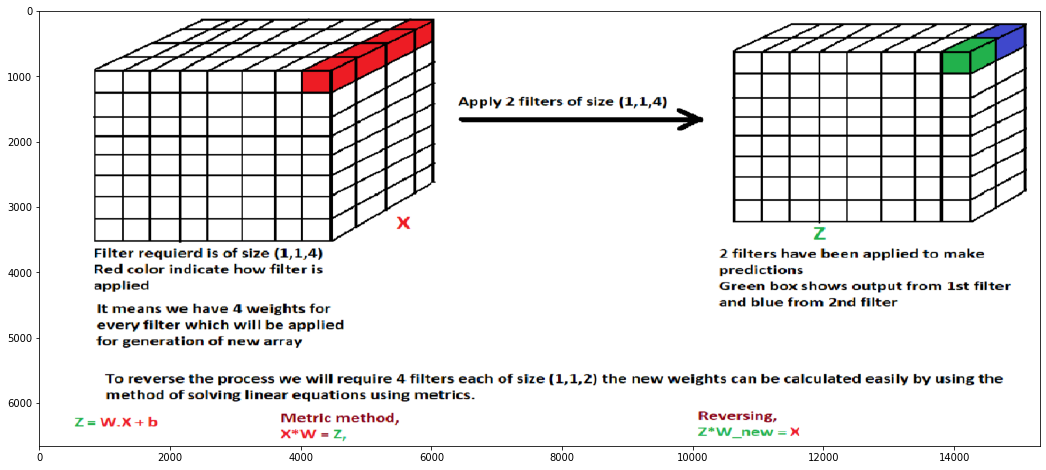

In [2]:
plt.figure(figsize = (20,8))
temp = plt.imread('/content/drive/MyDrive/2D_to_3D.png')
plt.imshow(temp)

In [ ]:
model_weights = model.weights   # take the weights from the trained model

# the weights taken directly have contain some unwanted string formated material
# Lets append just weights and biases to list
lst = list()
for i in model_weights:
    lst.append(np.array(i)) 
    
np.save('/content/model_weights.npy', lst)    # saving temperaly in cloud storage.
lst = np.load('/content/model_weights.npy', allow_pickle=True)

# now lets seperate the weights and biases and appending them in seperate list
weights = list()
bias = list()
for i in range(0,len(lst),2):
    weights.append(lst[i])
    bias.append(lst[i+1])

In [ ]:
# The formulization involved in the  the process is as follpw
# z = w.x + b

# so we need to find new metrics formed at every step. After that we will be able to calculate weights in reverse process

A = y_test[0]
list_A = list()
for i in np.arange(0,len(lst), 2):
    w = lst[i]
    b = lst[i+1]
    temp_shape = [110,88]
    temp_shape.append(w.shape[3])
    temp_A = np.empty(tuple(temp_shape))
    for j in range(w.shape[3]):
        # C_shape = [110,88]
        # C_shape.append(w.shape[2])
        C = np.empty((110,88))
        for k in range(w.shape[2]):
            C += np.multiply(A[:,:,k].reshape(110,88), w[:,:,k,j].reshape(1,1)).reshape(110,88)
        temp_A[:,:,j] = C + b[j]
        temp_A[temp_A<0] = 0
    list_A.append(temp_A)
    A = temp_A

In [ ]:
# calculate the weights, bias for reverse process

new_weights = list() 
new_bias = bias[::-1]   
new_list_A = list_A[::-1]
for i in range(len(new_list_A)-1):
    A = new_list_A[i][:new_list_A[i].shape[2],0,:] - new_bias[i]
    A_1_shape = list(new_list_A[i+1].shape)
    temp_shape = [1,1]
    temp_shape.append(new_list_A[i].shape[2])
    temp_shape.append(A_1_shape[2])
    print(temp_shape)
    #temp_shape = (list(new_list_A[i].shape)[2], list(A_1_shape)[2])
    temp_w = np.empty(tuple(temp_shape))
    for j in range(A_1_shape[2]):
        B = (new_list_A[i+1][:new_list_A[i].shape[-1],0,j] - new_bias[i+1][j])    # .reshape(110,1)
        # B = new_list_A[i+1][:,0,j].reshape(110,1)
        print(A.shape, B.shape)
        C = np.linalg.solve(A,B).reshape(1,1,new_list_A[i].shape[2])
        print(C.shape)
        temp_w[:,:,:,j] = C
    new_weights.append(temp_w)
    print(temp_w.shape, new_bias[i+1].shape)
    print('\n')

In [ ]:
# make the prediction
A = x[0][:,:88,:1]
for i in range(len(new_weights)):
    temp_shape = [110,88]
    temp_shape.append(new_weights[i].shape[-1])
    A_new = np.empty(tuple(temp_shape))
    for j in range(A_new.shape[-1]):
        temp_A = np.empty((110,88,1))
        for k in range(A.shape[-1]):
            print(A[:,:,k].shape, new_weights[i][0,0,:,k].shape)
            temp_A += np.multiply(A[:,:,k], new_weights[i][1,1,:,k])
            print(temp_A.shape)
    A_new[:,:,j] = temp_A - new_bias[i]
    A = A_new

In [ ]:
new = model.predict(x_train_in[0:1,].reshape(1,110,88,1))

In [ ]:
plt.imshow(x_test[0,:,:])

In [ ]:
plt.imshow(new[0,:,:,0])

These further steps are for reloading od saved data as the the notebook gets crashed due to limited hardware.

In [ ]:
x_0 = np.load('/content/Data_in_0.npy')
# y_0 = np.load('/content/Data_out_0.npy')

# x_train_0 = x_0[:65]
x_test_0 = x_0[65:]
# y_train_0 = y_0[:65]
# y_test_0 = y_0[65:]
# del x_0, y_train_0, y_test_0, y_0

# y_train = np.load('/content/y_train.npy')
y_test = np.load('/content/y_test.npy')

y_train_in = np.load('/content/y_train_in.npy')
x_train_in = np.load('/content/x_train_in.npy')

x_test = np.empty((15,110,88))
for s,i in enumerate(x_test_0):
  x_test[s] = cv2.resize(i, (88,110), interpolation = cv2.INTER_AREA)

# def r_squared(x,y):
#   x = np.array(x)
#   y = np.array(y)
#   slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x,y)
#   r_value = tf.TensorArray(r_value)
#   return r_value**2

In [ ]:
y_0 = np.load('/content/Data_out_0.npy')
x_train_0 = x_0[:65]
x_test_0 = x_0[65:]
y_train_0 = y_0[:65]
y_test_0 = y_0[65:]